In [1]:
# Run the notebook as if it's in the PROJECT directory
%bookmark PROJ_ROOT /reg/data/ana03/scratch/cwang31/pf
%cd -b PROJ_ROOT

(bookmark:PROJ_ROOT) -> /reg/data/ana03/scratch/cwang31/pf
/reg/data/ana03/scratch/cwang31/pf


In [2]:
# Load paths for using psana
%env SIT_ROOT=/reg/g/psdm/
%env SIT_DATA=/cds/group/psdm/data/
%env SIT_PSDM_DATA=/cds/data/psdm/

env: SIT_ROOT=/reg/g/psdm/
env: SIT_DATA=/cds/group/psdm/data/
env: SIT_PSDM_DATA=/cds/data/psdm/


In [3]:
import os
import torch
import random
import numpy as np
import h5py
import time

from peaknet.methods.unet       import UNet
from peaknet.model              import ConfigPeakFinderModel, PeakFinderModel
from peaknet.datasets.utils     import PsanaImg
from peaknet.datasets.transform import center_crop, coord_crop_to_img

from cupyx.scipy import ndimage
import cupy as cp

seed = 0

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
%matplotlib inline

## Load psana for accessing image data

In [5]:
# Sample Rayonix dataset
exp           = 'mfxp22820'
run           = 14
img_load_mode = 'calib'
access_mode   = 'idx'
detector_name = 'Rayonix'

psana_img = PsanaImg(exp, run, access_mode, detector_name)

## Load Model

In [6]:
timestamp = "2023_0321_1052_03"
epoch = 93
fl_chkpt = None if timestamp is None else f"{timestamp}.epoch_{epoch}.chkpt"

In [7]:
base_channels = 8
focal_alpha   = 0.8
focal_gamma   = 2.0
method = UNet( in_channels = 1, out_channels = 1, base_channels = base_channels )
config_peakfinder = ConfigPeakFinderModel( method = method,  
                                           focal_alpha = focal_alpha,
                                           focal_gamma = focal_gamma)
model = PeakFinderModel(config_peakfinder)
model.init_params()    # ..., load random weights 

In [8]:
# model.init_params(from_timestamp = timestamp)   # Run this will load a trained model
model.init_params(fl_chkpt = fl_chkpt)   # Run this will load a trained model

In [9]:
# Load model to gpus if available...
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
model  = torch.nn.DataParallel(model.method).to(device)

## Define hooks (Optional)

This is for for printing the metadata of the underlying neural networks.

In [ ]:
# Define hooks...
activation_dict = {}
preactivation_dict = {}
def get_activation(name, tag = ''):
    if tag not in preactivation_dict: preactivation_dict[tag] = {}
    if tag not in activation_dict: activation_dict[tag] = {}
    def hook(model, input, output):
        preactivation_dict[tag][name] = input
        activation_dict[tag][name] = output
    return hook

# Define what layer you want to check...
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.ReLU):
        layer.register_forward_hook(get_activation(name, 'relu'))

    if "final_conv" in name:
        layer.register_forward_hook(get_activation(name, 'final_conv'))

In [ ]:
# # Check out the shape of the output in each layer...
# class ReLUShapePrinter:
#     def __call__(self, module, input, output):
#         if isinstance(module, torch.nn.ReLU):
#             print(f"{module.__class__.__name__} output shape: {output.shape}")
            
# # Register the shape printer on each layer
# for name, module in model.named_modules():
#     module.register_forward_hook(ReLUShapePrinter())
            
# Check out the shape of the output in each layer...
class NonReLUShapePrinter:
    def __call__(self, module, input, output):
        if not isinstance(module, torch.nn.ReLU):
            print(f"{module.__class__.__name__} output shape: {output.shape}")

# Register the shape printer on each layer
for name, module in model.named_modules():
    module.register_forward_hook(NonReLUShapePrinter())

### Example of finding peaks in one image (access by event)

In [ ]:
# def remove_outliers(data):
#     """Removes outliers from a numpy array using the IQR method."""
#     q1, q3 = np.percentile(data, [5, 95])
#     iqr = q3 - q1
#     lower_bound = q1 - 1.5 * iqr
#     upper_bound = q3 + 1.5 * iqr
#     mask = np.logical_and(data >= lower_bound, data <= upper_bound)
#     return data * mask

Elapsed: 362.89402889087796 ms.


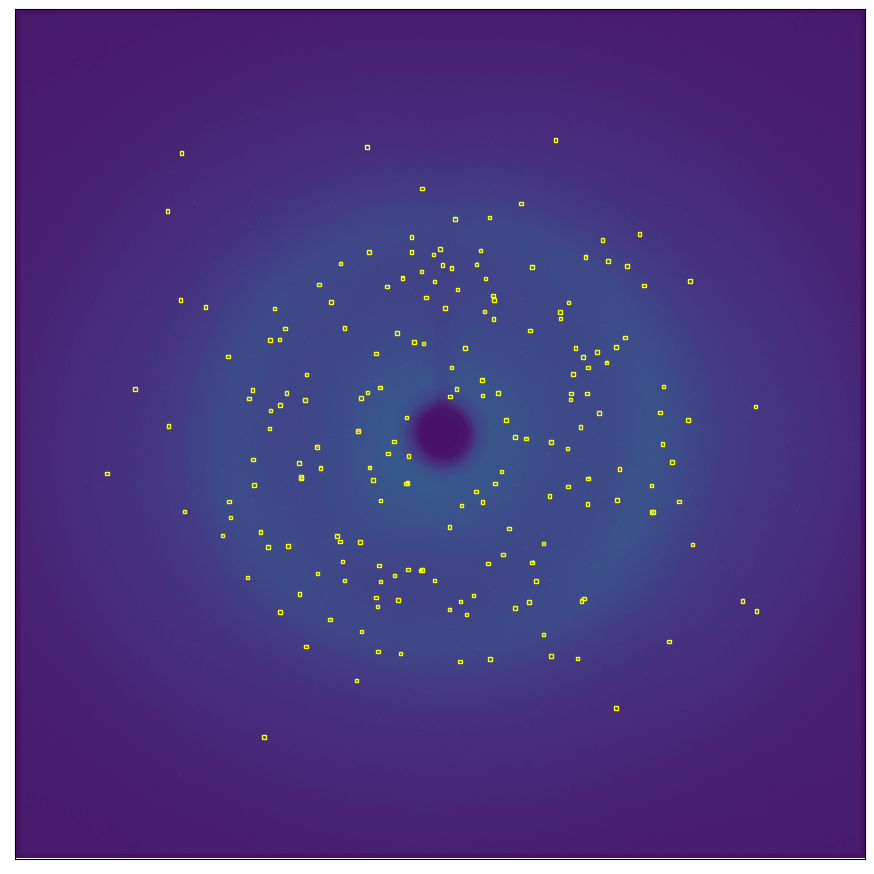

In [10]:
saves_plot = True

# Load images by event...
event = 14
img   = psana_img.get(event, None, 'calib')

mask = np.zeros_like(img)
offset = 10
size_y, size_x = img.shape
xmin = 0 + offset
xmax = size_x - offset
ymin = 0 + offset
ymax = size_y - offset
mask[ymin:ymax, xmin:xmax] = 1.0
img *= mask
img = torch.tensor(img).type(dtype=torch.float)[None,None,].to(device)
img = (img - img.mean()) / img.std()

model.eval()
time_start = time.monotonic()
with torch.no_grad():
    fmap = model.forward(img)
mask_predicted = fmap.sigmoid()
time_end = time.monotonic()
print(f"Elapsed: {(time_end - time_start) * 1e3} ms.")

threshold_prob = 0.5
mask_predicted[  mask_predicted < threshold_prob ] = 0
mask_predicted[~(mask_predicted < threshold_prob)] = 1

# Crop the original image...
size_y, size_x = mask_predicted.shape[-2:]
img_crop, offset_tuple = center_crop(img, size_y, size_x, returns_offset_tuple = True)

img_crop       = img_crop[0, 0].cpu().detach().numpy()
mask_predicted = mask_predicted[0, 0].cpu().detach().numpy()


# Locate peaks with coordinates...
structure = np.ones((3, 3), dtype=bool)
peak_predicted, num_peak_predicted = ndimage.label(cp.asarray(mask_predicted), structure)
peak_pos_predicted_list = ndimage.center_of_mass(cp.asarray(mask_predicted), peak_predicted, cp.asarray(range(1, num_peak_predicted+1)))

# [[[ Visual ]]]
# Set up the visual

ncols = 1
nrows = 1
# fig   = plt.figure(figsize = (16*5,14*5))
fig   = plt.figure(figsize = (8.5,8.5))
gspec = fig.add_gridspec( nrows, ncols,
                          width_ratios  = [1],
                          height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[0, 0], aspect = 1), ]

# Plot image
data = img_crop
vmin = np.mean(data) - 1 * data.std()
vmax = np.mean(data) + 6 * data.std()
im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
# im.set_clim(vmin, vmax)
# plt.colorbar(im, cax = ax_list[1], orientation="vertical", pad = 0.05)

ax_list[0].set_xticks([])
ax_list[0].set_yticks([])

# Plot mask overlay
data = mask_predicted
vmin = 0
vmax = 1
im2 = ax_list[0].imshow(data, vmin = vmin, vmax = vmax, alpha = 1.)
im2.set_clim(vmin, vmax)
cmap1 = mcolors.ListedColormap(['none', 'red'])
im2.set_cmap(cmap1)

# Place a box on a peak
offset = 4
b_offset = 2
for y, x in peak_pos_predicted_list:
    if np.isnan(y) or np.isnan(x): continue

    x_bottom_left = x.get() - offset
    y_bottom_left = y.get() - offset

    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                 2 * offset, 2 * offset, 
                                 linewidth = 1.0, 
                                 edgecolor = 'yellow', 
                                 facecolor='none')
    ax_list[0].add_patch(rec_obj)

    y_bmin, x_bmin = 0, 0
    y_bmax, x_bmax = size_y, size_x
    ax_list[0].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
    ax_list[0].set_ylim([y_bmin - b_offset, y_bmax + b_offset])

    
if saves_plot:
    drc_pdf  = "figures.paper"
    fl_pdf   = f"predict.{exp}.run{run}.event{event}.pdf"
    path_pdf = os.path.join(drc_pdf, fl_pdf)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
    fig.savefig(path_pdf, dpi = 300)

`%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% DIVIDER %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%`
<br/>
<br/>
<br/>
<br/>

Elapsed: 4.440660122781992 ms.


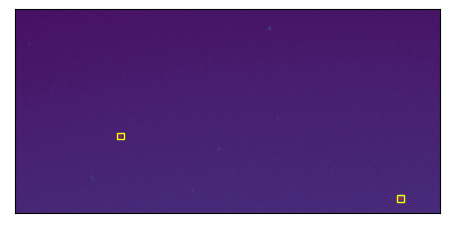

In [32]:
saves_plot = True

# Load images by event...
event = 5735
# event = 3101
# event = 1965
img   = psana_img.get(event, None, 'calib')

mask = np.zeros_like(img)
offset = 10
size_y, size_x = img.shape
xmin = 0 + offset
xmax = size_x - offset
ymin = 0 + offset
ymax = size_y - offset
mask[ymin:ymax, xmin:xmax] = 1.0
img *= mask
img = torch.tensor(img).type(dtype=torch.float)[None,None,].to(device)
img = (img - img.mean()) / img.std()

model.eval()
time_start = time.monotonic()
with torch.no_grad():
    fmap = model.forward(img)
mask_predicted = fmap.sigmoid()
time_end = time.monotonic()
print(f"Elapsed: {(time_end - time_start) * 1e3} ms.")

threshold_prob = 0.5
mask_predicted[  mask_predicted < threshold_prob ] = 0
mask_predicted[~(mask_predicted < threshold_prob)] = 1

# Crop the original image...
size_y, size_x = mask_predicted.shape[-2:]
img_crop, offset_tuple = center_crop(img, size_y, size_x, returns_offset_tuple = True)

img_crop       = img_crop[0, 0].cpu().detach().numpy()
mask_predicted = mask_predicted[0, 0].cpu().detach().numpy()


# Locate peaks with coordinates...
structure = np.ones((3, 3), dtype=bool)
peak_predicted, num_peak_predicted = ndimage.label(cp.asarray(mask_predicted), structure)
peak_pos_predicted_list = ndimage.center_of_mass(cp.asarray(mask_predicted), peak_predicted, cp.asarray(range(1, num_peak_predicted+1)))

# [[[ Visual ]]]
# Set up the visual

ncols = 1
nrows = 1
# fig   = plt.figure(figsize = (16*5,14*5))
fig   = plt.figure(figsize = (4.25,2.04))
gspec = fig.add_gridspec( nrows, ncols,
                          width_ratios  = [1],
                          height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[0, 0], aspect = 1), ]

# Plot image
data = img_crop
vmin = np.mean(data) - 1 * data.std()
vmax = np.mean(data) + 6 * data.std()
im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
# im.set_clim(vmin, vmax)
# plt.colorbar(im, cax = ax_list[1], orientation="vertical", pad = 0.05)

ax_list[0].set_xticks([])
ax_list[0].set_yticks([])

cy, cx = 1714+50, 830
win_y = 120
win_x = 250
size_y, size_x = img_crop.shape[-2:]
xmin = cx - win_x
xmax = cx + win_x
ymin = cy - win_y
ymax = cy + win_y
ax_list[0].set_xlim([xmin, xmax])
ax_list[0].set_ylim([ymin, ymax])


# Plot mask overlay
data = mask_predicted
vmin = 0
vmax = 1
im2 = ax_list[0].imshow(data, vmin = vmin, vmax = vmax, alpha = 1.)
im2.set_clim(vmin, vmax)
cmap1 = mcolors.ListedColormap(['none', 'red'])
im2.set_cmap(cmap1)

# Place a box on a peak
offset = 4
b_offset = 2
for y, x in peak_pos_predicted_list:
    if np.isnan(y) or np.isnan(x): continue

    x_bottom_left = x.get() - offset
    y_bottom_left = y.get() - offset

    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                 2 * offset, 2 * offset, 
                                 linewidth = 1.0, 
                                 edgecolor = 'yellow', 
                                 facecolor='none')
    ax_list[0].add_patch(rec_obj)

    y_bmin, x_bmin = 0, 0
    y_bmax, x_bmax = size_y, size_x
    # ax_list[0].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
    # ax_list[0].set_ylim([y_bmin - b_offset, y_bmax + b_offset])

    
if saves_plot:
    drc_pdf  = "figures.paper"
    fl_pdf   = f"predict.{exp}.run{run}.event{event}.top.pdf"
    path_pdf = os.path.join(drc_pdf, fl_pdf)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
    fig.savefig(path_pdf, dpi = 300)

Elapsed: 4.40201023593545 ms.


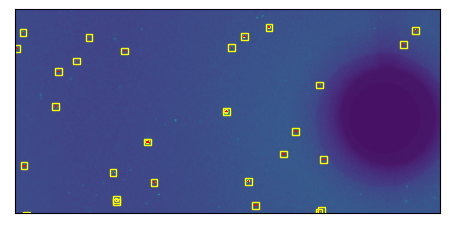

In [11]:
saves_plot = True

# Load images by event...
event = 14
# event = 3101
# event = 1965
img   = psana_img.get(event, None, 'calib')

mask = np.zeros_like(img)
offset = 10
size_y, size_x = img.shape
xmin = 0 + offset
xmax = size_x - offset
ymin = 0 + offset
ymax = size_y - offset
mask[ymin:ymax, xmin:xmax] = 1.0
img *= mask
img = torch.tensor(img).type(dtype=torch.float)[None,None,].to(device)
img = (img - img.mean()) / img.std()

model.eval()
time_start = time.monotonic()
with torch.no_grad():
    fmap = model.forward(img)
mask_predicted = fmap.sigmoid()
time_end = time.monotonic()
print(f"Elapsed: {(time_end - time_start) * 1e3} ms.")

threshold_prob = 0.5
mask_predicted[  mask_predicted < threshold_prob ] = 0
mask_predicted[~(mask_predicted < threshold_prob)] = 1

# Crop the original image...
size_y, size_x = mask_predicted.shape[-2:]
img_crop, offset_tuple = center_crop(img, size_y, size_x, returns_offset_tuple = True)

img_crop       = img_crop[0, 0].cpu().detach().numpy()
mask_predicted = mask_predicted[0, 0].cpu().detach().numpy()


# Locate peaks with coordinates...
structure = np.ones((3, 3), dtype=bool)
peak_predicted, num_peak_predicted = ndimage.label(cp.asarray(mask_predicted), structure)
peak_pos_predicted_list = ndimage.center_of_mass(cp.asarray(mask_predicted), peak_predicted, cp.asarray(range(1, num_peak_predicted+1)))

# [[[ Visual ]]]
# Set up the visual

ncols = 1
nrows = 1
# fig   = plt.figure(figsize = (16*5,14*5))
fig   = plt.figure(figsize = (4.25,2.04))
gspec = fig.add_gridspec( nrows, ncols,
                          width_ratios  = [1],
                          height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[0, 0], aspect = 1), ]

# Plot image
data = img_crop
vmin = np.mean(data) - 1 * data.std()
vmax = np.mean(data) + 6 * data.std()
im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
# im.set_clim(vmin, vmax)
# plt.colorbar(im, cax = ax_list[1], orientation="vertical", pad = 0.05)

ax_list[0].set_xticks([])
ax_list[0].set_yticks([])

cy, cx = 967, 776
win_y = 120
win_x = 250
size_y, size_x = img_crop.shape[-2:]
xmin = cx - win_x
xmax = cx + win_x
ymin = cy - win_y
ymax = cy + win_y
ax_list[0].set_xlim([xmin, xmax])
ax_list[0].set_ylim([ymin, ymax])


# Plot mask overlay
data = mask_predicted
vmin = 0
vmax = 1
im2 = ax_list[0].imshow(data, vmin = vmin, vmax = vmax, alpha = 1.)
im2.set_clim(vmin, vmax)
cmap1 = mcolors.ListedColormap(['none', 'red'])
im2.set_cmap(cmap1)

# Place a box on a peak
offset = 4
b_offset = 2
for y, x in peak_pos_predicted_list:
    if np.isnan(y) or np.isnan(x): continue

    x_bottom_left = x.get() - offset
    y_bottom_left = y.get() - offset

    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                 2 * offset, 2 * offset, 
                                 linewidth = 1.0, 
                                 edgecolor = 'yellow', 
                                 facecolor='none')
    ax_list[0].add_patch(rec_obj)

    y_bmin, x_bmin = 0, 0
    y_bmax, x_bmax = size_y, size_x
    # ax_list[0].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
    # ax_list[0].set_ylim([y_bmin - b_offset, y_bmax + b_offset])

    
if saves_plot:
    drc_pdf  = "figures.paper"
    fl_pdf   = f"predict.{exp}.run{run}.event{event}.size.pdf"
    path_pdf = os.path.join(drc_pdf, fl_pdf)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
    fig.savefig(path_pdf, dpi = 300)

```
Time delta: 47.3821 millisecond.
___/ Event 000016 \___
Time delta: 47.2331 millisecond.
___/ Event 000017 \___
Time delta: 47.2999 millisecond.
___/ Event 000018 \___
Time delta: 47.2839 millisecond.
___/ Event 000019 \___
Time delta: 47.2872 millisecond.
___/ Event 000020 \___
Time delta: 47.2953 millisecond.
___/ Event 000021 \___
Time delta: 47.3852 millisecond.
___/ Event 000022 \___
Time delta: 47.2968 millisecond.
___/ Event 000023 \___
Time delta: 47.3382 millisecond.
___/ Event 000024 \___
Time delta: 47.3099 millisecond.
___/ Event 000025 \___
Time delta: 47.4777 millisecond.
___/ Event 000026 \___
Time delta: 47.3394 millisecond.
___/ Event 000027 \___
Time delta: 47.2677 millisecond.
```

In [34]:
import pickle
fl_pickle = "demo/pf.2023_0321_1052_03.mfxp22820.run13.000000-008998.peaks.pickle"

with open(fl_pickle, 'rb') as handle:
    event_filtered_list = pickle.load(handle)

In [40]:
len(event_filtered_list)

414

In [39]:
event_filtered_list[0][1]

[(566.2, 920.4),
 (627.5, 1117.5),
 (640.0, 874.5),
 (652.6, 1223.8),
 (713.2, 929.6),
 (752.0, 1278.5),
 (788.0, 1193.2),
 (882.25, 611.0),
 (912.5, 1371.5),
 (959.1666666666666, 1241.8333333333333),
 (1031.6, 451.8),
 (1031.5, 858.5),
 (1038.4, 695.2),
 (1051.5, 1195.5),
 (1095.4, 1443.2),
 (1138.0, 1307.8333333333333),
 (1181.5, 1012.5),
 (1239.3333333333333, 606.6666666666666),
 (1245.5, 499.0),
 (1253.5, 675.5),
 (1300.6, 739.2),
 (1314.1666666666667, 1080.1666666666667)]

Elapsed: 5.01234782859683 ms.


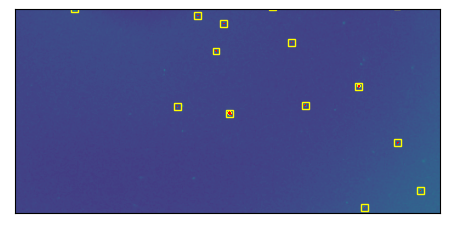

In [33]:
saves_plot = True

# Load images by event...
event = 5735
# event = 3101
# event = 1965
img   = psana_img.get(event, None, 'calib')

mask = np.zeros_like(img)
offset = 10
size_y, size_x = img.shape
xmin = 0 + offset
xmax = size_x - offset
ymin = 0 + offset
ymax = size_y - offset
mask[ymin:ymax, xmin:xmax] = 1.0
img *= mask
img = torch.tensor(img).type(dtype=torch.float)[None,None,].to(device)
img = (img - img.mean()) / img.std()

model.eval()
time_start = time.monotonic()
with torch.no_grad():
    fmap = model.forward(img)
mask_predicted = fmap.sigmoid()
time_end = time.monotonic()
print(f"Elapsed: {(time_end - time_start) * 1e3} ms.")

threshold_prob = 0.5
mask_predicted[  mask_predicted < threshold_prob ] = 0
mask_predicted[~(mask_predicted < threshold_prob)] = 1

# Crop the original image...
size_y, size_x = mask_predicted.shape[-2:]
img_crop, offset_tuple = center_crop(img, size_y, size_x, returns_offset_tuple = True)

img_crop       = img_crop[0, 0].cpu().detach().numpy()
mask_predicted = mask_predicted[0, 0].cpu().detach().numpy()


# Locate peaks with coordinates...
structure = np.ones((3, 3), dtype=bool)
peak_predicted, num_peak_predicted = ndimage.label(cp.asarray(mask_predicted), structure)
peak_pos_predicted_list = ndimage.center_of_mass(cp.asarray(mask_predicted), peak_predicted, cp.asarray(range(1, num_peak_predicted+1)))

# [[[ Visual ]]]
# Set up the visual

ncols = 1
nrows = 1
# fig   = plt.figure(figsize = (16*5,14*5))
fig   = plt.figure(figsize = (4.25,2.04))
gspec = fig.add_gridspec( nrows, ncols,
                          width_ratios  = [1],
                          height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[0, 0], aspect = 1), ]

# Plot image
data = img_crop
vmin = np.mean(data) - 1 * data.std()
vmax = np.mean(data) + 6 * data.std()
im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)
# im.set_clim(vmin, vmax)
# plt.colorbar(im, cax = ax_list[1], orientation="vertical", pad = 0.05)

ax_list[0].set_xticks([])
ax_list[0].set_yticks([])

cy, cx = 755, 1070
win_y = 120
win_x = 250
size_y, size_x = img_crop.shape[-2:]
xmin = cx - win_x
xmax = cx + win_x
ymin = cy - win_y
ymax = cy + win_y
ax_list[0].set_xlim([xmin, xmax])
ax_list[0].set_ylim([ymin, ymax])


# Plot mask overlay
data = mask_predicted
vmin = 0
vmax = 1
im2 = ax_list[0].imshow(data, vmin = vmin, vmax = vmax, alpha = 1.)
im2.set_clim(vmin, vmax)
cmap1 = mcolors.ListedColormap(['none', 'red'])
im2.set_cmap(cmap1)

# Place a box on a peak
offset = 4
b_offset = 2
for y, x in peak_pos_predicted_list:
    if np.isnan(y) or np.isnan(x): continue

    x_bottom_left = x.get() - offset
    y_bottom_left = y.get() - offset

    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                 2 * offset, 2 * offset, 
                                 linewidth = 1.0, 
                                 edgecolor = 'yellow', 
                                 facecolor='none')
    ax_list[0].add_patch(rec_obj)

    y_bmin, x_bmin = 0, 0
    y_bmax, x_bmax = size_y, size_x
    # ax_list[0].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
    # ax_list[0].set_ylim([y_bmin - b_offset, y_bmax + b_offset])

    
if saves_plot:
    drc_pdf  = "figures.paper"
    fl_pdf   = f"predict.{exp}.run{run}.event{event}.size.pdf"
    path_pdf = os.path.join(drc_pdf, fl_pdf)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
    fig.savefig(path_pdf, dpi = 300)

psocake vs peaknet

432 vs 414

322 vs 375

In [ ]:
465 vs 430
 vs 385
